# LangGraph 201: Building an Email Agent

In this notebook, we're going to walk through setting up an **email agent** in LangGraph. We will start from a simple ReAct-style agent and add additional steps into the workflow, simulating a realistic email assistant.


![Arch](../images/email_agent.png) 


For a deeper dive into LangGraph primitives and learning our framework, check out our [LangChain Academy](https://academy.langchain.com/courses/intro-to-langgraph)!


## Pre-work: Setup

### Loading Environment Variables

To start, let's load our environment variables from our .env file. Make sure all of the keys necessary in .env.example are included!
We use OpenAI in this example, but feel free to swap ChatOpenAI with other model providers that you prefer. 

In [1]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

load_dotenv(dotenv_path="../.env", override=True)

True

### Setting up Short and Long-Term Memory

We will also initialize a checkpointer for **short-term memory**, maintaining context within a single thread. 

**Long term memory** lets you store and recall information between conversations. Today, we will utilize our long term memory store to store user preferences for personalization. 

In [2]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.memory import InMemoryStore

# Initializing long term memory store 
in_memory_store = InMemoryStore()

# Initializing checkpoint for thread-level memory 
checkpointer = MemorySaver()

### Initialize our LLM

In [3]:
llm = ChatOpenAI(model="gpt-4.1", temperature=0.0)

# Note: If you are using another `ChatModel`, you can define it in `models.py` and import it here
# from models import AZURE_OPENAI_GPT_4O
# llm = AZURE_OPENAI_GPT_4O

## Part 1: Creating an Email Agent
![Arch](../images/email_response_agent.png)


### State

How does information flow through the steps?  

State is the first LangGraph concept we'll cover. **State can be thought of as the memory of the agent - its a shared data structure that’s passed on between the nodes of your graph**, representing the current snapshot of your application. 

For this our email agent our state will track the following elements: 
1. An input email
2. A classification decision - whether to respond to the email
3. The conversation history
4. Any loaded long-term memories
5. Remaining steps - before we hit our recurion limit

In [4]:
from typing_extensions import TypedDict
from typing import Annotated, Literal
from langgraph.graph.message import AnyMessage, add_messages

class State(TypedDict):
    # This state class has the messages key build in
    email_input: dict
    classification_decision: Literal["ignore", "respond", "notify"]
    messages: Annotated[list[AnyMessage], add_messages]
    loaded_memory: str
    remaining_steps: int



### Tools

Let's define a list of **tools** our agent will have access to. Tools are functionts that can act as extension of the LLM's capabilities. In our case, we will first create several tools that interacts with the Chinook database regarding music. 

We can create tools using the @tool decorator to create a tool

In [5]:
from langchain_core.tools import tool
from datetime import datetime
from pydantic import BaseModel

@tool
def schedule_meeting(
    attendees: list[str], subject: str, duration_minutes: int, preferred_day: datetime, start_time: int
) -> str:
    """Schedule a calendar meeting."""
    # Placeholder response - in real app would check calendar and schedule
    date_str = preferred_day.strftime("%A, %B %d, %Y")
    return f"Meeting '{subject}' scheduled on {date_str} at {start_time} for {duration_minutes} minutes with {len(attendees)} attendees"

@tool
def check_calendar_availability(day: str) -> str:
    """Check calendar availability for a given day."""
    # Placeholder response - in real app would check actual calendar
    return f"Available times on {day}: 9:00 AM, 2:00 PM, 4:00 PM"


@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send an email."""
    # Placeholder response - in real app would send email
    return f"Email sent to {to} with subject '{subject}' and content: {content}"

@tool
class Done(BaseModel):
    """E-mail has been sent."""
    done: bool

To make our LLM aware that these tools are available to call, we'll use the `bind_tools` method.

In [6]:
tools = [schedule_meeting, check_calendar_availability, write_email, Done]
tools_by_name = {tool.name: tool for tool in tools}

llm_with_tools = llm.bind_tools(tools, tool_choice="any", parallel_tool_calls=False)

### Nodes

Now that we have a list of tools, we are ready to build nodes that interact with them. 

Nodes are just python (or JS/TS!) functions. Nodes take in your graph's State as input, execute some logic, and return a new State. 

Here, we're just going to set up 2 nodes for our ReAct agent:
1. **reasoning**: Reasoning node that decides which function to invoke 
2. **tools**: Node that contains all the available tools and executes the function

LangChain has a ToolNode that we can utilize to create a node for our tools. 

In [7]:
from langchain.agents import ToolNode
# Node
tool_node = ToolNode(tools)

For email processing, let's define helpers to parse and format email inputs.

In [8]:
def parse_email(email_input: dict) -> dict:
    return (
        email_input["author"],
        email_input["to"],
        email_input["subject"],
        email_input["email_thread"],
    )

def format_email_markdown(subject, author, to, email_thread, email_id=None):
    id_section = f"\n**ID**: {email_id}" if email_id else ""
    
    return f"""

**Subject**: {subject}
**From**: {author}
**To**: {to}{id_section}

{email_thread}

---
"""


In [9]:
from langchain_core.messages import SystemMessage, HumanMessage

def create_agent_prompt(state: State):
    action_instructions = """
    < Role >
    You are a top-notch executive assistant who cares about helping your executive perform as well as possible.
    </ Role >

    < Tools >
    You have access to the following tools to help manage communications and schedule:

    1. write_email(to, subject, content) - Send emails to specified recipients
    2. schedule_meeting(attendees, subject, duration_minutes, preferred_day, start_time) - Schedule calendar meetings
    3. check_calendar_availability(day) - Check available time slots for a given day
    4. Done - E-mail has been sent
    </ Tools >

    < Instructions >
    When handling emails, follow these steps:
    1. Carefully analyze the email content and purpose
    3. For responding to the email, draft a response email with the write_email tool
    4. For meeting requests, use the check_calendar_availability tool to find open time slots
    5. To schedule a meeting, use the schedule_meeting tool with a datetime object for the preferred_day parameter
    - Today's date is {today} - use this for scheduling meetings accurately
    6. If you scheduled a meeting, then draft a short response email using the write_email tool
    7. After using the write_email tool, the task is complete
    8. If you have sent the email, then use the Done tool to indicate that the task is complete
    </ Instructions >

    < Background >
    I'm Robert, a software engineer at LangChain.
    </ Background >

    < Response Preferences >
    Use professional and concise language. If the e-mail mentions a deadline, make sure to explicitly acknowledge and reference the deadline in your response.

    When responding to technical questions that require investigation:
    - Clearly state whether you will investigate or who you will ask
    - Provide an estimated timeline for when you'll have more information or complete the task

    When responding to event or conference invitations:
    - Always acknowledge any mentioned deadlines (particularly registration deadlines)
    - If workshops or specific topics are mentioned, ask for more specific details about them
    - If discounts (group or early bird) are mentioned, explicitly request information about them
    - Don't commit 

    When responding to collaboration or project-related requests:
    - Acknowledge any existing work or materials mentioned (drafts, slides, documents, etc.)
    - Explicitly mention reviewing these materials before or during the meeting
    - When scheduling meetings, clearly state the specific day, date, and time proposed.

    When responding to meeting scheduling requests:
    - If the recipient is asking for a meeting commitment, verify availability for all time slots mentioned in the original email and then commit to one of the proposed times based on your availability by scheduling the meeting. Or, say you can't make it at the time proposed.
    - If availability is asked for, then check your calendar for availability and send an email proposing multiple time options when available. Do NOT schedule meetings
    - Mention the meeting duration in your response to confirm you've noted it correctly.
    - Reference the meeting's purpose in your response.
    </ Response Preferences >

    < Calendar Preferences >
    30 minute meetings are preferred, but 15 minute meetings are also acceptable.
    Times later in the day are preferable.
    </ Calendar Preferences >
    """

    email = parse_email(state["email_input"])
    email_markdown = format_email_markdown(email[2], email[0], email[1], email[3])
    email_request = f"Please respond to the following email: {email_markdown}"

    prompt = [
        SystemMessage(action_instructions.format(today=datetime.now().strftime("%Y-%m-%d"))),
        HumanMessage(content=email_request)
    ]

    return prompt + state["messages"]

# Nodes
def reasoning_node(state: State):
    """LLM decides whether to call a tool or not"""
    prompt = create_agent_prompt(state)
    result = llm_with_tools.invoke(prompt)

    return {"messages": [result]}

### Edges

Now, we need to define a control flow that connects between our defined nodes, and that's where the concept of edges come in.

**Edges are connections between nodes. They define the flow of the graph.**
* **Normal edges** are deterministic and always go from one node to its defined target
* **Conditional edges** are used to dynamically route between nodes, implemented as functions that return the next node to visit based upon some logic. 

In this case, we want a **conditional edge** from our subagent that determines whether to: 
- Invoke tools, or,
- Route to the end if user query has been finished 

In [10]:
from langgraph.graph import END, START

def should_continue(state: State) -> Literal["Tools", "__end__"]:
    """Route to Tools, or end if Done tool called"""
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        for tool_call in last_message.tool_calls: 
            if tool_call["name"] == "Done":
                return END
            else:
                return "Tools"

### Compile Graph!

Now that we've defined our State and Nodes, let's put it all together and construct our react agent!

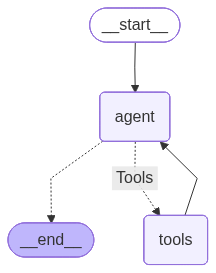

In [11]:
from langgraph.graph import StateGraph

# Build workflow
agent_builder = StateGraph(State)

# Add nodes
agent_builder.add_node("agent", reasoning_node)
agent_builder.add_node("tools", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "agent")
agent_builder.add_conditional_edges(
    "agent",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Tools": "tools",
        END: END,
    },
)
agent_builder.add_edge("tools", "agent")

# Compile the agent
agent = agent_builder.compile(checkpointer=checkpointer, store=in_memory_store)
agent

### Testing
Let's see how our agent responds to emails!

In [12]:
import uuid
thread_id = uuid.uuid4()

config = {"configurable": {"thread_id": thread_id}}

email_input = {
    "to": "Robert Xu <Robert@company.com>",
    "author": "Team Lead <teamlead@company.com>",
    "subject": "Quarterly planning meeting",
    "email_thread": "Hi Robert,\n\nIt's time for our quarterly planning session. I'd like to schedule a 90-minute meeting next week to discuss our roadmap for Q3.\n\nCould you let me know your availability for Monday or Wednesday? Ideally sometime between 10AM and 3PM.\n\nLooking forward to your input on the new feature priorities.\n\nBest,\nTeam Lead"
}

result = agent.invoke({"email_input": email_input}, config=config)

print("Responding to email: ")
print(format_email_markdown(email_input["subject"], email_input["author"], email_input["to"], email_input["email_thread"]))

for message in result["messages"]:
    message.pretty_print()

Responding to email: 


**Subject**: Quarterly planning meeting
**From**: Team Lead <teamlead@company.com>
**To**: Robert Xu <Robert@company.com>

Hi Robert,

It's time for our quarterly planning session. I'd like to schedule a 90-minute meeting next week to discuss our roadmap for Q3.

Could you let me know your availability for Monday or Wednesday? Ideally sometime between 10AM and 3PM.

Looking forward to your input on the new feature priorities.

Best,
Team Lead

---

================================== Ai Message ==================================
Tool Calls:
  check_calendar_availability (call_rSIpKwVWS111bjT9gpGmhBsB)
 Call ID: call_rSIpKwVWS111bjT9gpGmhBsB
  Args:
    day: 2025-10-20
================================= Tool Message =================================
Name: check_calendar_availability

Available times on 2025-10-20: 9:00 AM, 2:00 PM, 4:00 PM
================================== Ai Message ==================================
Tool Calls:
  check_calendar_availability (cal

## Part 2: Using a Prebuilt

The architecture we created for our email agent is a a common architecture known as a ReAct agent. This tool-calling format is very popular, so LangChain actually provides a prebuilt function to easily spin up ReAct agents.

Let's reimplement our agent using the prebuilt!

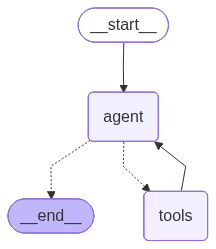

In [ ]:
from langchain.agents import create_agent

# Define the subagent 
email_prebuilt = create_agent(
    model=llm, 
    tools=tools, 
    name="email_prebuilt",
    system_prompt=create_agent_prompt, 
    state_schema=State, 
    checkpointer=checkpointer, 
    store=in_memory_store
)
email_prebuilt

Let's go ahead and test our prebuilt!

In [14]:
import uuid
thread_id = uuid.uuid4()

config = {"configurable": {"thread_id": thread_id}}

email_input = {
    "to": "Robert Xu <Robert@company.com>",
    "author": "Team Lead <teamlead@company.com>",
    "subject": "Quarterly planning meeting",
    "email_thread": "Hi Robert,\n\nIt's time for our quarterly planning session. I'd like to schedule a 90-minute meeting next week to discuss our roadmap for Q3.\n\nCould you let me know your availability for Monday or Wednesday? Ideally sometime between 10AM and 3PM.\n\nLooking forward to your input on the new feature priorities.\n\nBest,\nTeam Lead"
}

result = email_prebuilt.invoke({"email_input": email_input}, config=config)

print("Responding to email: ")
print(format_email_markdown(email_input["subject"], email_input["author"], email_input["to"], email_input["email_thread"]))

for message in result["messages"]:
    message.pretty_print()

Responding to email: 


**Subject**: Quarterly planning meeting
**From**: Team Lead <teamlead@company.com>
**To**: Robert Xu <Robert@company.com>

Hi Robert,

It's time for our quarterly planning session. I'd like to schedule a 90-minute meeting next week to discuss our roadmap for Q3.

Could you let me know your availability for Monday or Wednesday? Ideally sometime between 10AM and 3PM.

Looking forward to your input on the new feature priorities.

Best,
Team Lead

---

================================== Ai Message ==================================
Name: email_prebuilt
Tool Calls:
  check_calendar_availability (call_nF5AwOfkNrjQhzNZV4EeGG4n)
 Call ID: call_nF5AwOfkNrjQhzNZV4EeGG4n
  Args:
    day: 2025-10-20
  check_calendar_availability (call_UBuywqngDtuz3OAcgJxQLQVd)
 Call ID: call_UBuywqngDtuz3OAcgJxQLQVd
  Args:
    day: 2025-10-22
================================= Tool Message =================================
Name: check_calendar_availability

Available times on 2025-10-20: 9:

## Part 3: Human-in-the-Loop

![Arch](../images/email_agent.png)

In many agents, high reliability agents require human approval or feedback before taking action. In our case, our email agent should determine whether to ignore or respond to an email, but it might not always be able to make that decision on its own.

As such, we will allow the email agent to ask the human for help when dealing with emails. We'll also demonstrate how to bring this functionality into a more complex workflow involving multiple agentic steps.

We will be utilizing **human-in-the-loop** to provide the LLM human feedback on whether to ignore or respond to an email.

### Adding Triage Capabilities

First, let's add a new step in our workflow. We want the agent to be able to triage emails and decide whether they are worth responding to. To do this, we'll add a new "triage" node.

We'll start by defining a schema for our LLM to adhere to with it's output.

In [15]:
from pydantic import BaseModel, Field

class RouterSchema(BaseModel):
    """Analyze the unread email and route it according to its content."""

    reasoning: str = Field(
        description="Step-by-step reasoning behind the classification."
    )
    classification: Literal["ignore", "respond", "notify"] = Field(
        description="The classification of an email: 'ignore' for irrelevant emails, "
        "'notify' for important information that doesn't need a response, "
        "'respond' for emails that need a reply",
    )

llm_router = llm.with_structured_output(RouterSchema)

We'll then create the triage node itself, alongside its prompt.

In [16]:
from langchain_core.messages import SystemMessage, HumanMessage

def create_triage_prompt(state: State):
    loaded_memory = ""
    if "loaded_memory" in state:
        loaded_memory = state["loaded_memory"]

    triage_instructions = f"""
    < Role >
    Your role is to triage incoming emails based upon instructs and background information below.
    </ Role >

    < Background >
    I'm Robert, a software engineer at LangChain.
    </ Background >

    < Instructions >
    Categorize each email into one of three categories:
    1. IGNORE - Emails that are not worth responding to or tracking
    2. NOTIFY - Important information that worth notification but doesn't require a response
    3. RESPOND - Emails that need a direct response
    Classify the below email into one of these categories.
    </ Instructions >

    < Rules >
    Emails that are not worth responding to:
    - Marketing newsletters and promotional emails
    - Spam or suspicious emails
    - CC'd on FYI threads with no direct questions

    There are also other things that should be known about, but don't require an email response. For these, you should notify (using the `notify` response). Examples of this include:
    - Team member out sick or on vacation
    - Build system notifications or deployments
    - Project status updates without action items
    - Important company announcements
    - FYI emails that contain relevant information for current projects
    - HR Department deadline reminders
    - GitHub notifications

    Emails that are worth responding to:
    - Direct questions from team members requiring expertise
    - Meeting requests requiring confirmation
    - Critical bug reports related to team's projects
    - Requests from management requiring acknowledgment
    - Client inquiries about project status or features
    - Technical questions about documentation, code, or APIs (especially questions about missing endpoints or features)
    - Personal reminders related to family (wife / daughter)
    - Personal reminder related to self-care (doctor appointments, etc)
    </ Rules >

    {loaded_memory}
    """
    author, to, subject, email_thread = parse_email(state["email_input"])
    email_markdown = format_email_markdown(subject, author, to, email_thread)
    email_request = f"Please determine how to handle the below email thread: {email_markdown}"
    prompt = [
        SystemMessage(triage_instructions),
        HumanMessage(content=email_request)
    ] + state["messages"]
    return prompt

def triage_router(state: State):
    """
    Analyze email content to decide if we should respond, notify, or ignore.
    """
    prompt = create_triage_prompt(state)
    # Run the router LLM
    result = llm_router.invoke(prompt)

    # Decision
    classification = result.classification
    return  { "classification_decision": classification }


We'll also create a node to add human feedback when the agent decides to `notify` the human. These are emails the agent classifies as important, but aren't worthy of a response. We'll have the human user validate whether or not these important emails actually DO deserve a response.

In [17]:
from langgraph.types import interrupt

# Node
def human_input(state: State):
    """ Node to incoporate human feedback """
    author, to, subject, email_thread = parse_email(state["email_input"])
    email_markdown = format_email_markdown(subject, author, to, email_thread)
    user_input = interrupt(f"Please determine whether the following email deserves a response (Y/n): {email_markdown}")

    log = "Email originally marked as notify, but user flagged it as a scneario where a response is warranted."
    if str(user_input).lower() == "y":
        return { "classification_decision": "respond", "messages": [HumanMessage(content=log)]}
    else:
        return { "classification_decision": "ignore" }


Finally, we'll define the new edges that we'll need. We'll define an edge that triggers Human In the Loop if the triage step returns a `notify` classification, as well as an edge from our human feedback step to the rest of the agent.

In [18]:
def handle_classification(state: State):
    """ Trigger human review if the email is classified as notify """
    if state["classification_decision"] == "notify":
        return "human_input"
    elif state["classification_decision"] == "respond":
        return "email_agent"
    else:
        return END


def handle_human_input(state: State):
    """ Handle human input """
    if state["classification_decision"] == "respond":
        return "email_agent"
    else:
        return END


Let's compile our agent!

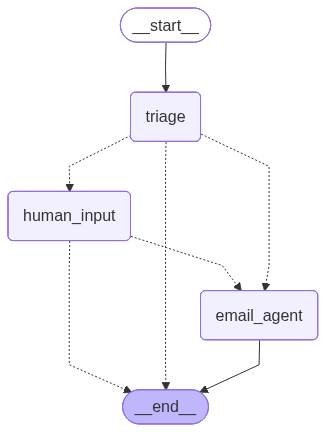

In [19]:
email_hitl_workflow = StateGraph(State)
email_hitl_workflow.add_node("triage", triage_router)
email_hitl_workflow.add_node("human_input", human_input)
email_hitl_workflow.add_node("email_agent", agent)
email_hitl_workflow.add_edge(START, "triage")
email_hitl_workflow.add_conditional_edges(
    "triage",
    handle_classification,
    {
        "human_input": "human_input",
        "email_agent": "email_agent",
        END: END,
    },
)
email_hitl_workflow.add_conditional_edges(
    "human_input",
    handle_human_input,
    {
        "email_agent": "email_agent",
        END: END,
    },
)
email_hitl = email_hitl_workflow.compile(checkpointer=checkpointer, store=in_memory_store)
email_hitl



### Testing

Let's invoke our new agent!

In [20]:
import uuid
thread_id = uuid.uuid4()

config = {"configurable": {"thread_id": thread_id}}

email_input = {
    "to": "Robert Xu <Robert@company.com>",
    "author": "System Admin <sysadmin@company.com>",
    "subject": "Scheduled maintenance - database downtime",
    "email_thread": "Hi Robert,\n\nThis is a reminder that we'll be performing scheduled maintenance on the production database tonight from 2AM to 4AM EST. During this time, all database services will be unavailable.\n\nPlease plan your work accordingly and ensure no critical deployments are scheduled during this window.\n\nThanks,\nSystem Admin Team"
}

result = email_hitl.invoke({"email_input": email_input}, config=config)

if "__interrupt__" in result:
    print("Classification decision: ", result["classification_decision"])
    print("----- Human assistance required -----")
    print(result["__interrupt__"][0].value)
else:
    for message in result["messages"]:
        message.pretty_print()


Classification decision:  notify
----- Human assistance required -----
Please determine whether the following email deserves a response (Y/n): 

**Subject**: Scheduled maintenance - database downtime
**From**: System Admin <sysadmin@company.com>
**To**: Robert Xu <Robert@company.com>

Hi Robert,

This is a reminder that we'll be performing scheduled maintenance on the production database tonight from 2AM to 4AM EST. During this time, all database services will be unavailable.

Please plan your work accordingly and ensure no critical deployments are scheduled during this window.

Thanks,
System Admin Team

---



In [21]:
from langgraph.types import Command

result = email_hitl.invoke(Command(resume="y"), config=config)

for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Email originally marked as notify, but user flagged it as a scneario where a response is warranted.
================================== Ai Message ==================================
Tool Calls:
  write_email (call_epPG5qHttQ7nJORuLMphSdTv)
 Call ID: call_epPG5qHttQ7nJORuLMphSdTv
  Args:
    to: sysadmin@company.com
    subject: Re: Scheduled maintenance - database downtime
    content: Hello System Admin Team,

Thank you for the reminder regarding the scheduled maintenance window tonight from 2AM to 4AM EST. I will ensure that no critical deployments are planned during this period and will notify my team accordingly.

Please let me know if there are any changes to the maintenance schedule.

Best regards,
Robert Xu
================================= Tool Message =================================
Name: write_email

Email sent to sysadmin@company.com with subject 'Re: Scheduled maintenance - database downtime'

## [Optional] Part 4: Memory

Now that we have created an agent workflow that includes verification and execution, let's take it a step further. 

**Long term memory** lets you store and recall information between conversations. We have already initialized a long term memory store. 


![memory](../images/email_agent_memory.png)

In this step, we will add 2 nodes: 
- **load_memory** node that loads from the long term memory store
- **create_memory** node that saves any music interests that the customer has shared about themselves 

Let's start with load memory. This will allow us to personalize what emails we want our agent to respond to, without hard-coding it into the prompt.

In [22]:
from langgraph.store.base import BaseStore
from langgraph.types import RunnableConfig

# helper function to structure memory 
def format_user_memory(user_data):
    """Formats music preferences from users, if available."""
    profile = user_data['memory']
    result = "<Additional Rules>\n"
    result += "The following are custom rules the user has noted to be important. Please prioritize these rules:"
    if hasattr(profile, 'response_preferences') and profile.response_preferences:
        result += f"{'\n- '.join(profile.response_preferences)}"
    result += "\n</Additional Rules>"
    
    return result.strip()

# Node
def load_memory(state: State, store: BaseStore):
    """Loads music preferences from users, if available."""
    
    namespace = ("memory_profile", "Robert")
    existing_memory = store.get(namespace, "user_memory")
    formatted_memory = ""
    if existing_memory and existing_memory.value:
        formatted_memory = format_user_memory(existing_memory.value)

    return {"loaded_memory" : formatted_memory}

Next, we'll make our create_memory node. We'll use structured output to ensure all our memories are in the same format.

In [23]:
# User profile structure for creating memory
from typing import List

class UserProfile(BaseModel):
    response_preferences: List[str] = Field(
        description="A list of rules describing what types of email the user would like to respond to"
    )

In [24]:
create_memory_prompt = """You are an expert analyst that is observing a conversation that has taken place between a customer and an executive assistant. The executive assistant helps the customer handle their emails.
You are tasked with analyzing the interaction that has taken place between the customer and the executive assistant, and updating the memory profile associated with the customer. 
You specifically care about saving any music interest the customer has shared about themselves, particularly their music preferences to their memory profile.

<core_instructions>
1. The memory profile may be empty. If it's empty, you should ALWAYS create a new memory profile for the customer.
2. You should identify what characteristics about the email resulted in the user wanting to respond to it.
3. For each key in the memory profile, if there is no new information, do NOT update the value - keep the existing value unchanged.
4. ONLY update the values in the memory profile if there is new information.
</core_instructions>

<expected_format>
The customer's memory profile should have the following fields:
- response_preferences: a list of rules describing what types of email the user would like to respond to

IMPORTANT: ENSURE your response is an object with these fields.
</expected_format>


<important_context>
**IMPORTANT CONTEXT BELOW**
To help you with this task, I have attached the conversation that has taken place between the customer and the customer support assistant below, as well as the existing memory profile associated with the customer that you should either update or create. 

The conversation between the customer and the customer support assistant that you should analyze is as follows:
{conversation}

The existing memory profile associated with the customer that you should either update or create based on the conversation is as follows:
{memory_profile}

</important_context>

Reminder: Take a deep breath and think carefully before responding.
"""

# Node
def create_memory(state: State, store: BaseStore):
    namespace = ("memory_profile", "Robert")
    formatted_memory = state["loaded_memory"]

    email_input = state["email_input"]
    formatted_email = format_email_markdown(email_input["subject"], email_input["author"], email_input["to"], email_input["email_thread"])
    initial_message = f"Initial email received: {formatted_email}\n"
    conversation = HumanMessage(content=initial_message) + state["messages"]

    formatted_system_message = SystemMessage(content=create_memory_prompt.format(conversation=conversation, memory_profile=formatted_memory))
    updated_memory = llm.with_structured_output(UserProfile).invoke([formatted_system_message])
    key = "user_memory"
    store.put(namespace, key, {"memory": updated_memory})

Let's add these nodes to our graph. We'll only create a new memory when the user has offered feedback. In other words, we'll only create a new memory when the user has decided to respond to an email originally marked as "notify only".

In [25]:
def should_create_memory(state: State):
    """ Only create a new memory if the user has decided to respond to an email """
    messages = state["messages"]

    correction = "Email originally marked as notify, but user flagged it as a scneario where a response is warranted."
    for message in messages:
        if message.type == "human" and correction in message.content:
            return "create_memory"

    return END


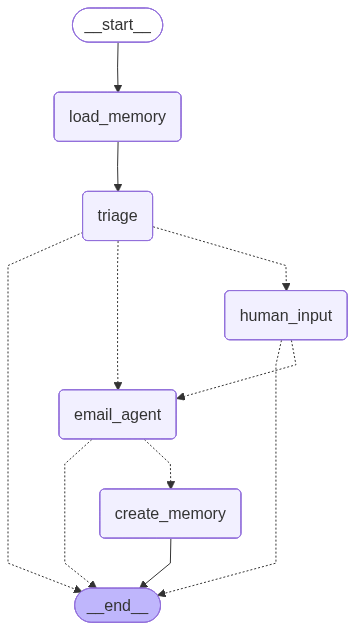

In [26]:
email_memory_workflow = StateGraph(State)
email_memory_workflow.add_node("triage", triage_router)
email_memory_workflow.add_node("human_input", human_input)
email_memory_workflow.add_node("email_agent", agent)

email_memory_workflow.add_node("load_memory", load_memory)
email_memory_workflow.add_node("create_memory", create_memory)

email_memory_workflow.add_edge(START, "load_memory")
email_memory_workflow.add_edge("load_memory", "triage")


email_memory_workflow.add_conditional_edges(
    "triage",
    handle_classification,
    {
        "human_input": "human_input",
        "email_agent": "email_agent",
        END: END,
    },
)
email_memory_workflow.add_conditional_edges(
    "human_input",
    handle_human_input,
    {
        "email_agent": "email_agent",
        END: END,
    },
)
email_memory_workflow.add_conditional_edges(
    "email_agent",
    should_create_memory,
    {
        "create_memory": "create_memory",
        END: END,
    },
)

email_agent_memory = email_memory_workflow.compile(checkpointer=checkpointer, store=in_memory_store)
email_agent_memory

In [27]:
import uuid
thread_id = uuid.uuid4()

config = {"configurable": {"thread_id": thread_id}}

email_input = {
    "to": "Robert Xu <Robert@company.com>",
    "author": "System Admin <sysadmin@company.com>",
    "subject": "Scheduled maintenance - database downtime",
    "email_thread": "Hi Robert,\n\nThis is a reminder that we'll be performing scheduled maintenance on the production database tonight from 2AM to 4AM EST. During this time, all database services will be unavailable.\n\nPlease plan your work accordingly and ensure no critical deployments are scheduled during this window.\n\nThanks,\nSystem Admin Team"
}

result = email_agent_memory.invoke({"email_input": email_input}, config=config)
result = email_agent_memory.invoke(Command(resume="y"), config=config)


print("Responding to email: ")
print(format_email_markdown(email_input["subject"], email_input["author"], email_input["to"], email_input["email_thread"]))

for message in result["messages"]:
    message.pretty_print()


Responding to email: 


**Subject**: Scheduled maintenance - database downtime
**From**: System Admin <sysadmin@company.com>
**To**: Robert Xu <Robert@company.com>

Hi Robert,

This is a reminder that we'll be performing scheduled maintenance on the production database tonight from 2AM to 4AM EST. During this time, all database services will be unavailable.

Please plan your work accordingly and ensure no critical deployments are scheduled during this window.

Thanks,
System Admin Team

---

================================ Human Message =================================

Email originally marked as notify, but user flagged it as a scneario where a response is warranted.
================================== Ai Message ==================================
Tool Calls:
  write_email (call_TxnznkznQknQHcfM5Q2N9uhX)
 Call ID: call_TxnznkznQknQHcfM5Q2N9uhX
  Args:
    to: sysadmin@company.com
    subject: Re: Scheduled maintenance - database downtime
    content: Hello,

Thank you for the reminde

Let's check out what our agent stored in memory

In [28]:
user = "Robert"
namespace = ("memory_profile", user)
memory = in_memory_store.get(namespace, "user_memory").value

saved_preferences = memory.get("memory").response_preferences

print(saved_preferences)

['The user would like to respond to operational or system notification emails (such as scheduled maintenance notices) when they require acknowledgment, confirmation of actions to be taken, or when the user feels it is important to communicate awareness and readiness to the sender.']
